In [1]:
import zipfile
import os
#pyspark imports
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, md5, sum as spark_sum
#matplotlib imports
import matplotlib.pyplot as plt

In [2]:
spark = SparkSession.builder.appName("SMS Billing").getOrCreate()

In [3]:
#Definir la ruta del archivo zip
zip_file_path = '/home/jovyan/data/test_grandata_data_engineer.zip'

In [4]:
#Crear un directorio para los archivos extraidos
extraction_path = '/home/jovyan/data/extracted_files'
os.makedirs(extraction_path, exist_ok=True)

In [5]:
#Descomprimir el archivo
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

In [6]:
#Listar los archivos extraidos
extracted_files = os.listdir(extraction_path)
print("Archivos extraidos:", extracted_files)

Archivos extraidos: ['__MACOSX', 'test_grandata_data_engineer']


In [7]:
#Cargar datasets
eventos_df = spark.read.csv("/home/jovyan/data/extracted_files/test_grandata_data_engineer/events.csv.gz", header=True, inferSchema=True)
free_sms_df = spark.read.csv("/home/jovyan/data/extracted_files/test_grandata_data_engineer/free_sms_destinations.csv.gz", header=True, inferSchema=True)

In [8]:
eventos_df = eventos_df.na.drop(subset=['id_source', 'id_destination'])

In [9]:
eventos_df.show(20, truncate=False)

+----+-----+-------+---+--------+------+---------+--------------+
|hour|calls|seconds|sms|date    |region|id_source|id_destination|
+----+-----+-------+---+--------+------+---------+--------------+
|11  |1    |24     |0  |20211001|5     |BF3      |374           |
|1   |1    |51     |0  |20211001|4     |9F5      |374           |
|11  |1    |3      |0  |20211001|6     |025      |374           |
|10  |1    |36     |0  |20211001|5     |FB6      |D52           |
|23  |4    |137    |0  |20211001|8     |4BB      |861           |
|18  |0    |0      |1  |20211001|4     |90C      |5B0           |
|13  |1    |618    |0  |20211001|9     |7AB      |4CA           |
|16  |1    |172    |0  |20211001|9     |7AB      |4CA           |
|6   |1    |208    |0  |20211001|9     |7AB      |4CA           |
|5   |1    |66     |0  |20211001|9     |7AB      |4CA           |
|18  |1    |135    |0  |20211001|9     |7AB      |4CA           |
|12  |0    |0      |8  |20211001|9     |0A4      |465           |
|21  |1   

In [10]:
#Calculo del monto total
sms_cost_df = eventos_df.join(free_sms_df, eventos_df.id_destination == free_sms_df.id, "left") \
    .withColumn("sms_cost", when(col("id_destination") == free_sms_df.id, 0)
        .when(col("region").between(1, 5), 1.5) 
        .when(col("region").between(6, 9), 2.0)
    ) \
    .groupBy("id_source") \
    .agg(spark_sum("sms_cost").alias("total_sms_cost"))

In [11]:
total_sms_cost = sms_cost_df.agg(spark_sum("total_sms_cost")).collect()[0][0]
print(f"Monto total que facturara el proveedor: ${total_sms_cost}")

Monto total que facturara el proveedor: $1696022.5


In [12]:
# generar dataset de usuarios con mayor facturacion
top_users_df = sms_cost_df.orderBy(col("total_sms_cost").desc()).limit(100) \
.withColumn("hashed_id", md5(col("id_source")))
top_users_df.write.parquet("/home/jovyan/results/top_users.parquet", mode="overwrite", compression="gzip")
# Leer el dataset de usuarios con mayor facturación
top_users_df = spark.read.parquet("/home/jovyan/results/top_users.parquet")
top_users_df.show(truncate=False)

+---------+--------------+--------------------------------+
|id_source|total_sms_cost|hashed_id                       |
+---------+--------------+--------------------------------+
|4D3      |18573.0       |911914c7729eedbdf5b0f03159f451a9|
|76D      |13508.0       |bd180b7811395cbce5076b52a78ca50d|
|07E      |4070.0        |14a0660ae2f5d186882df86c2972fa93|
|541      |1707.0        |16c222aa19898e5058938167c8ab6c57|
|B86      |1292.5        |bc97b32ee2abb9c18aad55b9da9f51c0|
|3AE      |1026.0        |6a57072949dbc409cc48ef7bd8b05335|
|1BD      |1023.5        |f5a45e33602ea62f9498f9d9bb86fc3e|
|3E0      |1015.5        |e9d076deb3451cc49819dbc8ed8be7a7|
|D29      |892.0         |1b2e80021b5fc82bf4e6878cab310d9e|
|E6F      |714.5         |159e1f3d6ff0e7c3c2ff9770edc52cdf|
|D67      |702.0         |4e321438558549248e9ffc0195b8f4ef|
|871      |680.0         |aeb3135b436aa55373822c010763dd54|
|8F1      |652.0         |496ce5f942d15eefb26cd9e9f83bf869|
|383      |626.5         |beed13602b9b0e

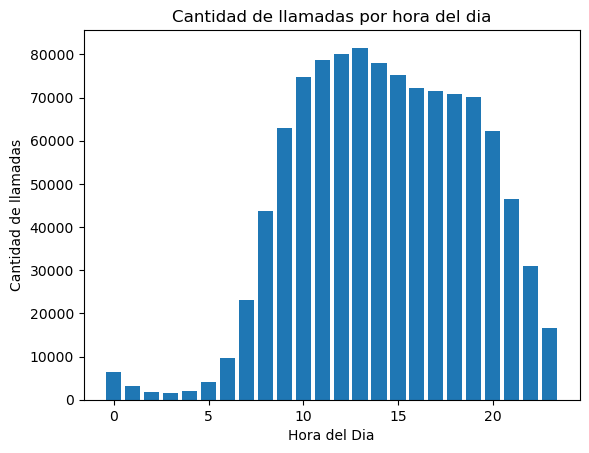

In [13]:
# graficar histograma de cantidad de llamadas por hora
#contar llamadas por hora
calls_by_hour_df = eventos_df.groupBy("hour").agg(spark_sum("calls").alias("total_calls")).orderBy("hour")
calls_by_hour = calls_by_hour_df.toPandas()

#Graficar Histograma
plt.bar(calls_by_hour['hour'], calls_by_hour['total_calls'])
plt.xlabel('Hora del Dia')
plt.ylabel('Cantidad de llamadas')
plt.title('Cantidad de llamadas por hora del dia')
plt.savefig('results/calls_histogram.png')
plt.show()

In [14]:
spark.stop()